In [1]:
import math, random

import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
#basic
import numpy as np
import pandas as pd
#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
#image processing
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.segmentation import felzenszwalb
from skimage.morphology import closing, square
from skimage.color import label2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.transform import rescale
#visialization
from PIL import Image
import cv2
#scikit 
from scipy.spatial import distance_matrix
from scipy.spatial import distance
#graph
import networkx as nx
#language model
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#other
from copy import deepcopy
from itertools import count
from joblib import dump, load
from joblib import Parallel, delayed
import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from gym import spaces

# helping functions

In [4]:
def show_image(img):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)

In [5]:
def make_video(States,name="test",width=160,height=210,channel=3,fps=60):
    fourcc = cv2.VideoWriter_fourcc(*'XVID') 
    video = cv2.VideoWriter(name+'.avi', fourcc, float(fps), (width,height))

    for i in range(States.shape[0]):
        video.write(States[i])

    video.release()

In [6]:
def visualize_objects(label_image,image):
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)

    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= 1:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc-0.5, minr-0.5), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=3)
            ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [7]:
def find_objects(image,thresh=None):
    #image = rgb2gray(image)

    if thresh is None:
        thresh = threshold_otsu(image)*0.9
    # label image regions
    label_image = label(image > thresh)
    
    return label_image, thresh

In [8]:
def find_cut_objects(image,m_h,m_w,thresh=None,grayscale=False):
    label_image,_=find_objects(image,thresh=thresh)
    regions=regionprops(label_image)

    i=len(regions)+1
    for reg in regions:
        i=i+1
        minr, minc, maxr, maxc = reg.bbox
        if int(np.ceil((maxc-minc)/m_w))!=1:
            split_w=np.linspace(0,(maxc-minc),1+int(np.ceil((maxc-minc)/m_w))).astype("int")
            for y in range(int(np.ceil((maxc-minc)/m_w))):
                i=i+1
                label_image[reg.slice][:,split_w[y]:split_w[y+1]][reg.image[:,split_w[y]:split_w[y+1]]]=i
    
    regions=regionprops(label_image)
    for reg in regions:
        i=i+1
        minr, minc, maxr, maxc = reg.bbox
        if int(np.ceil((maxr-minr)/m_h))!=1:
            split_h=np.linspace(0,(maxr-minr),1+int(np.ceil((maxr-minr)/m_h))).astype("int")
            for x in range(int(np.ceil((maxr-minr)/m_h))):
                i=i+1
                label_image[reg.slice][split_h[x]:split_h[x+1],:][reg.image[split_h[x]:split_h[x+1],:]]=i


    regions=regionprops(label_image)
    
    if grayscale:
        image=rgb2gray(image)
    
    objects=np.array([np.zeros((m_h,m_w)) for reg in regions])
    for i in range(len(regions)):
        x=regions[i].image.shape[0]
        y=regions[i].image.shape[1]
        objects[i,(m_h-x)//2:(m_h-x)//2+x,(m_w-y)//2:(m_w-y)//2+y]=image[regions[i].slice]
    
    
    return label_image, objects, regions

In [9]:
def regions_to_graph(regions,labels,prox=60):
    #weighted?
    centroids=np.array([reg.centroid for reg in regions])
    if prox==0:
        dist=np.zeros((len(centroids),len(centroids)))
    else:
        dist=distance_matrix(centroids,centroids)
        dist=(dist<prox)*dist
    G = nx.from_numpy_matrix(dist)
    lab={x:str(labels[x]) for x in range(len(centroids))}
    nx.set_node_attributes(G, lab, "feature")
    pos_x={x:int(centroids[x][0]) for x in range(len(centroids))}
    nx.set_node_attributes(G, pos_x, "position_x")
    pos_y={x:int(centroids[x][1]) for x in range(len(centroids))}
    nx.set_node_attributes(G, pos_y, "position_y")
    return G

In [10]:
def graph_to_doc(Graphs,iterations=2,start_tag=0):
    documents=[]
    hashes=None
    for i in range(len(Graphs)):
        if iterations>0:
            hashes=nx.weisfeiler_lehman_subgraph_hashes(Graphs[i], iterations=iterations, node_attr="feature")
            
        Doc=[]
        for node in Graphs[i].nodes:
            Doc=Doc+[Graphs[i].nodes[node]["feature"],"pos_x"+str(Graphs[i].nodes[node]["position_x"]),"pos_y"+str(Graphs[i].nodes[node]["position_y"]),
                    "apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5),"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                    Graphs[i].nodes[node]["feature"]+"pos_x"+str(Graphs[i].nodes[node]["position_x"]),
                     Graphs[i].nodes[node]["feature"]+"pos_y"+str(Graphs[i].nodes[node]["position_y"]),
                    Graphs[i].nodes[node]["feature"]+"apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5),
                     Graphs[i].nodes[node]["feature"]+"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                     Graphs[i].nodes[node]["feature"]+"apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5)+"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                     Graphs[i].nodes[node]["feature"]+"pos_x"+str(Graphs[i].nodes[node]["position_x"])+Graphs[i].nodes[node]["feature"]+"pos_y"+str(Graphs[i].nodes[node]["position_y"]),
                     "apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5)+"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                     "pos_x"+str(Graphs[i].nodes[node]["position_x"])+Graphs[i].nodes[node]["feature"]+"pos_y"+str(Graphs[i].nodes[node]["position_y"])                   
                    ]
            if iterations>0:
                Doc=Doc+hashes[node]
        
        documents=documents+[Doc.copy()]
    
    return documents

In [11]:
def doc_to_embedding(documents,model,seed=42):
    model.random.seed(seed)
    return np.array([model.infer_vector(doc) for doc in documents])

In [12]:
def visualize_graph(g,max_col=15):
    nodes = g.nodes()
    colors = [int(g.nodes[n]['feature'])/max_col for n in nodes]
    pos = nx.spring_layout(g)
    for n in nodes:
        pos[n][1]=-1*g.nodes[n]['position_x']
        pos[n][0]=g.nodes[n]['position_y']

    ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=150, cmap=plt.cm.jet,vmin=0,vmax=1)
    #plt.colorbar(nc)
    plt.axis('off')
    plt.show()

In [13]:
def graph_diff2(G1,G2,obj_class_diff=100,obj_n_diff=100):
    n1=set([(G1.nodes[x]["feature"],G1.nodes[x]["position_x"],G1.nodes[x]["position_y"]) for x in G1.nodes])
    n2=set([(G2.nodes[x]["feature"],G2.nodes[x]["position_x"],G2.nodes[x]["position_y"]) for x in G2.nodes])
    l1=list(n1.difference(n2))
    l2=list(n2.difference(n1))
    
    if len(l1)==0 or len(l2)==0:
        return abs(len(l1)-len(l2))*obj_n_diff
    
    if len(l1)>len(l2):
        l1,l2 = l2,l1
    
    dist=np.zeros((len(l1),len(l2)))
    for x in range(len(l1)):
        for y in range(len(l2)):
            dist[x,y]=node_dist(l1[x],l2[y],obj_class_diff=obj_class_diff)
        
    return graph_metric(dist,obj_n_diff=obj_n_diff)

In [14]:
def node_dist2(n1,n2,obj_class_diff=100):
    return (n1[0]!=n2[0])*obj_class_diff+abs(n1[1]-n2[1])+abs(n1[2]-n2[2])

In [15]:
def node_dist(n1,n2,obj_class_diff=100):
    return (n1[0]!=n2[0])*obj_class_diff+np.sqrt((n1[1]-n2[1])**2+(n1[2]-n2[2])**2)

In [16]:
def graph_metric(dist,obj_n_diff=100):
    return np.sum(np.min(dist,axis=1))+abs(dist.shape[0]-dist.shape[1])*obj_n_diff

In [17]:
def graph_diff(G1,G2,obj_class_diff=100,obj_n_diff=100):
    l1=[(G1.nodes[x]["feature"],G1.nodes[x]["position_x"],G1.nodes[x]["position_y"]) for x in G1.nodes]
    l2=[(G2.nodes[x]["feature"],G2.nodes[x]["position_x"],G2.nodes[x]["position_y"]) for x in G2.nodes]
    
    if len(l1)==0 or len(l2)==0:
        return abs(len(l1)-len(l2))*obj_n_diff
    
    if len(l1)>len(l2):
        l1,l2 = l2,l1
    
    dist=np.zeros((len(l1),len(l2)))
    for x in range(len(l1)):
        for y in range(len(l2)):
            dist[x,y]=node_dist(l1[x],l2[y],obj_class_diff=obj_class_diff)
        
    return graph_metric(dist,obj_n_diff=obj_n_diff)

In [18]:
def graph_diff3(l1,l2,obj_class_diff=100,obj_n_diff=100):

    if len(l1)==0 or len(l2)==0:
        return abs(len(l1)-len(l2))*obj_n_diff
    
    if len(l1)>len(l2):
        l1,l2 = l2,l1
    
    c1=np.array([[l[1],l[2]] for l in l1])
    c2=np.array([[l[1],l[2]] for l in l2])
    
    lab1=np.array([[int(l[0])] for l in l1])
    lab2=np.array([[int(l[0])] for l in l2])
    
    dist=euclidean_distances(c1,c2)+obj_class_diff*(euclidean_distances(lab1,lab2)>0)
        
    return np.sum(np.min(dist,axis=1))+abs(dist.shape[0]-dist.shape[1])*obj_n_diff

In [19]:
def graph_diff_list(G1_list,G2_list,obj_class_diff=100,obj_n_diff=100):
    L1=[[(G1.nodes[x]["feature"],G1.nodes[x]["position_x"],G1.nodes[x]["position_y"]) for x in G1.nodes] for G1 in G1_list]
    L2=[[(G2.nodes[x]["feature"],G2.nodes[x]["position_x"],G2.nodes[x]["position_y"]) for x in G2.nodes] for G2 in G2_list]
    
    dist=np.zeros((len(L1),len(L2)))
    for x in range(len(L1)):
        for y in range(len(L2)):
            dist[x,y]=graph_diff3(L1[x],L2[y])
            if dist[x,y]==0:
                break
        
    return dist

In [20]:
def regions_to_embedding(regions,labels,grid,label_size=16,x=105,y=80,max_rad=10):
    centroids=np.array([reg.centroid for reg in regions])
    dist=distance_matrix(centroids,grid)
    dist=(1-np.clip(dist/max_rad,0,1))#**2
    emb=np.zeros((label_size+1,grid.shape[0]))
    emb[0,:]=dist.sum(axis=0)
    for lab in np.unique(labels):
        emb[lab+1,:]=dist[labels==lab,:].sum(axis=0)
        
    return emb

In [21]:
def make_grid(shape,x=2,y=2):
    grid=np.zeros((x*y,2))
    split_h=np.linspace(0,shape[0],y).astype("int")
    split_w=np.linspace(0,shape[1],x).astype("int")
    z=0
    for i in split_h:
        for j in split_w:
            grid[z,:]=[i,j]
            z+=1
    return grid

In [22]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

<h3>Use Cuda</h3>

In [23]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

<h2>Replay Buffer</h2>

In [24]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

<h2>Deep Q Network</h2>

In [25]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(state).unsqueeze(0))
                
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [26]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 256),
            nn.ReLU(),
            nn.Linear(256, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0))
                
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

<h2>Computing Temporal Difference Loss</h2>

In [27]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    
    with torch.no_grad():
        next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [28]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.plot(moving_average(rewards,10))
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<p><hr></p>

<h1>Atari Environment</h1>

In [29]:
class SkipWrapper(gym.Wrapper):
    def __init__(self, env, repeat_action=4):
        gym.Wrapper.__init__(self, env)
        self.repeat_action= repeat_action

    def step(self, action):
        total_reward=0
        for i in range(self.repeat_action):
            next_state, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
                
        return next_state, total_reward, done, info

In [30]:
class GridWrapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.num_clusters=10
        self.x_grid=10
        self.y_grid=10
        self.grid=make_grid((84,84),self.x_grid,self.y_grid)
        self.max_rad=distance.euclidean([0,0],[84//self.x_grid,84//self.y_grid])
        self.out_dim=(1+self.num_clusters)*self.x_grid*self.y_grid
        
    def preprocess_state(self, state):
        label_image, regions, labels=state
        embedding=regions_to_embedding(regions,labels,self.grid,label_size=self.num_clusters,max_rad=self.max_rad).reshape(-1)
        #clip emmbeding
        embedding=np.clip(embedding,-2, 2)
        return embedding
        
    def step(self, actions):
        orig_state, reward, terminal, info = self.env.step(actions)
        embedding=self.preprocess_state(orig_state)
        next_state=embedding
        return next_state, reward, terminal, info

In [31]:
class OtsuWrapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.max_obj_height=8
        self.max_obj_width=8
        self.threshold=None
    
    def preprocess_state(self, state):
        if self.threshold is None:
            _,self.threshold=find_objects(state)
        
        #cut objects
        label_image, objects, regions=find_cut_objects(state,self.max_obj_height,self.max_obj_width,self.threshold)
        return label_image, objects, regions
        
    def step(self, actions):
        orig_state, reward, terminal, info = self.env.step(actions)
        label_image, objects, regions=self.preprocess_state(orig_state)
        next_state=(label_image, objects, regions)
        return next_state, reward, terminal, info

In [32]:
class PcaWrapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.pca_n_components=10
        self.pca_model=IncrementalPCA(n_components=self.pca_n_components)
        self.train_pca=True
        
    def preprocess_state(self, state):
        label_image, objects, regions=state
        X=objects.reshape(objects.shape[0],-1)
        if self.train_pca:
            self.pca_model.partial_fit(np.vstack((np.unique(X,axis=0),np.unique(X,axis=0))))
        
        objects_compressed=self.pca_model.transform(X)
        return label_image, objects_compressed, regions 
        
    def step(self, actions):
        orig_state, reward, terminal, info = self.env.step(actions)
        label_image, objects_compressed, regions =self.preprocess_state(orig_state)
        next_state=(label_image, objects_compressed, regions)
        return next_state, reward, terminal, info

In [33]:
class BirchWrapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.num_clusters=10
        self.birch_model=Birch(n_clusters=None,threshold=0.5,branching_factor=50)
        self.train_birch=True
        
    def preprocess_state(self, state):
        label_image, objects_compressed, regions=state
        if self.train_birch:
            self.birch_model.partial_fit(objects_compressed)
            if self.birch_model.n_clusters is None and len(self.birch_model.subcluster_labels_)>self.num_clusters:
                self.birch_model.set_params(n_clusters=self.num_clusters)
                self.birch_model.partial_fit()
        
        labels=self.birch_model.predict(objects_compressed)
        
        for i in range(len(labels)):
            label_image[regions[i].slice][regions[i].image]=labels[i]+1
        
        return label_image, regions, labels
        
    def step(self, actions):
        orig_state, reward, terminal, info = self.env.step(actions)
        label_image, regions, labels=self.preprocess_state(orig_state)
        next_state=(label_image, regions, labels)
        return next_state, reward, terminal, info

In [34]:
class SemanticWrapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        
        #semantic model
        self.ready=False
        self.dimensions=128
        self.observation_space = gym.spaces.Box(low=-2.0, high=2.0, shape=(self.dimensions,), dtype=np.float32)
        self.prox=20
        self.hash_iterations=2
        self.starting_doc_len=30000
        self.start_tag=0
        self.min_count=2
        self.seed=42
        self.workers = 8
        self.epochs = 20
        self.learning_rate = 0.025
        self.window=16
        self.hs=1
        self.dm=0
        self.negative=0
        self.max_vocab_size=30000
        self.semantic_model=Doc2Vec(
            vector_size=self.dimensions,
            window=self.window,
            min_count=self.min_count,
            dm=self.dm,
            hs=self.hs,
            negative=self.negative,
            workers=self.workers,
            epochs=self.epochs,
            alpha=self.learning_rate,
            max_vocab_size=self.max_vocab_size,
            seed=self.seed
        )
        
    def train_semantic(self,regions_list,labels_list):
        Graphs=[regions_to_graph(regions,labels,prox=self.prox) for regions,labels in zip(regions_list,labels_list)]
        Doc_all=graph_to_doc(Graphs,iterations=self.hash_iterations,start_tag=0)
        
        documents = [
                TaggedDocument(words=doc, tags=[i])
                for i, doc in enumerate(Doc_all)
            ]
    
        self.semantic_model.build_vocab(documents)
        self.semantic_model.train(documents,total_examples=len(documents),epochs=self.semantic_model.epochs)
        self.ready=True
    
    def preprocess_state(self, state):
        label_image, regions, labels=state
        
        if self.ready:
            #make graph
            graph=regions_to_graph(regions,labels,prox=self.prox)

            doc=graph_to_doc([graph],iterations=self.hash_iterations,start_tag=0)

            #make embedding
            embedding=doc_to_embedding(doc,self.semantic_model,seed=42)

            #clip emmbeding
            embedding=np.clip(embedding,-2, 2)[0]
        else:
            embedding=np.zeros(self.dimensions)
        
        return embedding
        
    def step(self, actions):
        orig_state, reward, terminal, info = self.env.step(actions)
        embedding=self.preprocess_state(orig_state)
        next_state=embedding
        return next_state, reward, terminal, info

In [35]:
class ResetWrapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(0)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [36]:
class ActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.action_space=spaces.Discrete(2)
    
    def action(self, act):
        act={0:2,1:3,2:2}[act]
        return act

In [37]:
class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=1,
            shape=(self.height, self.width), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame.reshape(self.width,self.height)/255.0

In [38]:
class StateDiff(gym.Wrapper):
    def __init__(self, env,stacking=False):
        gym.Wrapper.__init__(self, env)
        self.last_state = None
        self.stacking=stacking

    def reset(self):
        state = self.env.reset()
        self.last_state=state
        if self.stacking:
            return np.stack((state, state-self.last_state), axis=0)
        else:    
            return np.concatenate((state, state-self.last_state), axis=-1)

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        if self.stacking:
            next_state=np.stack((state, state-self.last_state), axis=0)
        else:    
            next_state=np.concatenate((state, state-self.last_state), axis=-1)
        self.last_state=state
        return next_state, reward, done, info

In [39]:
class LabelWrapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    
    def preprocess_state(self, state):
        label_image, objects, regions=state
        return label_image
        
    def step(self, actions):
        orig_state, reward, terminal, info = self.env.step(actions)
        label_image=self.preprocess_state(orig_state)
        next_state=label_image
        return next_state, reward, terminal, info

In [40]:
def check_stability_pca(object_list,old_compression,pca_model,stability_threshold=0.01):
    obj=object_list.pop(0)
    obj=obj.reshape(obj.shape[0],-1)
    new=pca_model.transform(obj)
    old=old_compression.pop(0)
    err=mean_absolute_error(new,old)
    if err<stability_threshold:
        return True, err
    else:
        return False, err

In [41]:
def check_stability_birch(object_compressed_list,old_labels,birch_model,stability_threshold=0.95):
    obj=object_compressed_list.pop(0)
    new=birch_model.predict(obj)
    old=old_labels.pop(0)
    acc=balanced_accuracy_score(new,old)
    if acc>stability_threshold:
        return True, acc
    else:
        return False, acc

# Train

In [42]:
prefix='Grid_'

In [43]:
env_start=gym.make('PongNoFrameskip-v4')
env_start=SkipWrapper(env_start)
env_start=WarpFrame(env_start)
env_act=ActionWrapper(env_start)
env_otsu=OtsuWrapper(env_act)
env_pca=PcaWrapper(env_otsu)
env_birch=BirchWrapper(env_pca)
env_grid=GridWrapper(env_birch)
env=ResetWrapper(env_grid)
env=StateDiff(env)

A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


# PCA warm up

In [44]:
lookback=250
num_frames = 1000
state = env.reset()
object_list=[]
old_compression=[]
err_list=[]
ok=False
for frame_idx in range(1, num_frames + 1):
    
    action = random.randrange(env.action_space.n)
    next_state, reward, done, _ = env_otsu.step(action)
    object_list.append(next_state[1])
    old_compression.append(env_pca.preprocess_state(next_state)[1])
    state = next_state

    if len(object_list)>lookback:
        ok,err=check_stability_pca(object_list,old_compression,env_pca.pca_model,stability_threshold=0.05)
        err_list.append(err)
    
    if ok:
        print("PCA stable after "+str(frame_idx)+" frames" )
        env_pca.train_pca=False
        break
    
    if done:
        state = env.reset()

PCA stable after 342 frames


In [45]:
np.save(prefix+'pca_err.npy',np.array(err_list))

dump(env_pca.pca_model, prefix+'pca_model.joblib') 

['Grid_pca_model.joblib']

# Birch warm up

In [46]:
lookback=250
num_frames = 1000
state = env.reset()
object_compressed_list=[]
old_labels=[]
acc_list=[]
ok=False
for frame_idx in range(1, num_frames + 1):
    
    action = random.randrange(env.action_space.n)
    next_state, reward, done, _ = env_pca.step(action)
    object_compressed_list.append(next_state[1])
    old_labels.append(env_birch.preprocess_state(next_state)[2])
    state = next_state

    if len(object_compressed_list)>lookback:
        ok,acc=check_stability_birch(object_compressed_list,old_labels,env_birch.birch_model,stability_threshold=0.01)
        acc_list.append(acc)
    
    if ok:
        print("Birch stable after "+str(frame_idx)+" frames" )
        env_birch.train_birch=False
        break
    
    if done:
        state = env.reset()

Birch stable after 251 frames


In [47]:
np.save(prefix+'birch_acc.npy',np.array(acc_list))

dump(env_birch.birch_model, prefix+'birch_model.joblib') 

['Grid_birch_model.joblib']

# create model

In [48]:
model = DQN(env_grid.out_dim*2, env.action_space.n)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.0001)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

In [49]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [50]:
num_frames = 2000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0
tic = datetime.datetime.now()

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        print(frame_idx)
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        tac = datetime.datetime.now()
        print(str(10000/(tac-tic).total_seconds())+" frames per sec")
        tic = tac

888
1834


In [51]:
import hiddenlayer as hl

In [52]:
y=Variable(torch.FloatTensor(np.float32(state)))

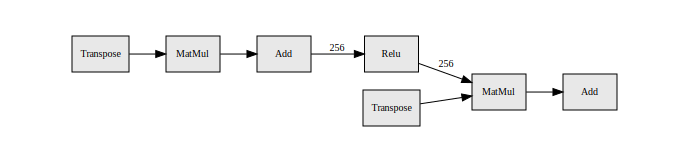

In [53]:
hl.build_graph(model, y)

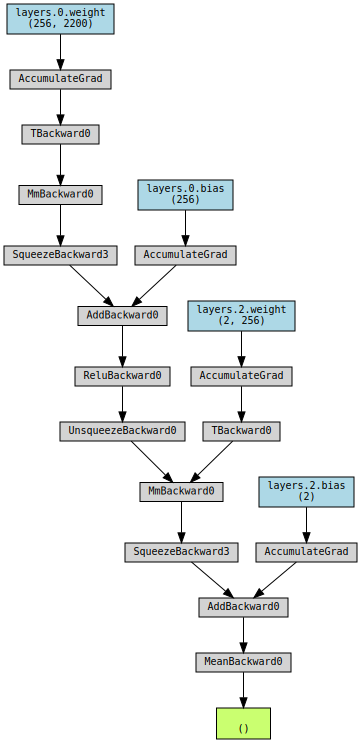

In [54]:
from torchviz import make_dot

y=Variable(torch.FloatTensor(np.float32(state)))

y=model(y)

make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=False, show_saved=False)

In [55]:
torch.save(model, prefix+"model.pt")

np.save(prefix+'rewards.npy',all_rewards)

np.save(prefix+'losses.npy',losses)